## Intensity comparison - bic/non-bic - epitope blocking experiments
- <a href='#modules'>Import modules</a>
- <a href='#specifydirectory'>Specify experiment directory</a>
- <a href='#makedict'>Make empty dictionary to store results</a>
- <a href='#makepdfs'>Make PDFs of raw images</a>
- <a href='#loadingprocessinganalysing'>Loading, processing and batch analyzing the images</a>
    - <a href='#preprocessing'>Preprocessing</a>
    - <a href='#segmenting'>Segmenting</a>
- <a href='#quantitativeimageanalysis'>Quantitative image analysis</a>
- <a href='#plots'>Plots</a>
    - <a href='#checknormality'>Check normality</a>
    - <a href='#barplots'>Barplots</a>
    - <a href='#boxwhisker'>Box and whisker plots</a>
    - <a href='#violinplots'>Violin plots</a>
- <a href='#makingsense'>Making sense</a>

<a id='modules'></a> 
### Import modules
These contain all the functions we will be using for the analysis

In [99]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio

<a id='specifydirectory'></a> 
### Specify experiment directory
- Experimental conditions are named after the folders in the directory
- Channel numbers of each condition (ECM, synapses, nuclei) is read from the file channels.txt in the directory

In [100]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Golgi_block/' #master folder
protein="TNR" #TNR,Agg,WFA,HABP

<a id='makedict'></a> 
### Make an empty dictionary to store all the results we want to calculate
- The dictionary 'results' will store the mean of each result for each image (e.g. mean intensity of the image)
- The dictionary 'histogram_results' will store the histograms of the intensities for each image
- The dictionary 'region_props' will store the region properties of the 'spots' (individual, discrete objects) that are detected in the images in the segmentation stage. These are morphological/geographical parameters like location, area, perimeter, etc.

In [101]:
results = {"filename":[],
           "ecmchannelno":[],"nucleichannelno":[],"synapsechannelno":[],"noblock_controldir":[],
           "Soma mask from synapse channel":[],
           "Neurites mask from synapse channel":[],
           "Manual soma mask from matlab GUI":[],
           "Manual neurites mask from matlab GUI":[],
           "exp condition":[],
           "ECM raw intensity, unmasked":[],
           "Nuclei raw intensity, unmasked":[],
           "Synapse raw intensity, unmasked":[],
           "ECM intensity: unmasked, divded by unblocked condition":[],
           "ECM mean intensity: soma only":[],
           "ECM mean intensity: soma only, divided by unblocked":[],
           "ECM mean intensity: neurites only":[],
           "ECM mean intensity: neurites only, divided by unblocked":[],
           "ECM mean intensity: matlab manual soma mask only":[],
           "ECM mean intensity: matlab manual soma mask only, divided by unblocked":[],
           "ECM mean intensity: matlab manual neurites mask only":[],
           "ECM mean intensity: matlab manual neurites mask only, divided by unblocked":[],
           
           "Synapse mean intensity: soma only":[],
           "Synapse mean intensity: neurites only":[],
           "Synapse mean intensity: matlab manual mask only":[],
           "Nuclei mean intensity: soma only":[],
           "Nuclei mean intensity: neurites only":[],
           "Nuclei mean intensity: matlab manual mask only":[],
           "Number of synapse spots in soma mask":[],
           "Number of synapse spots in neurites mask":[],
           "Number of synapse spots in matlab manual mask":[],
           "Number of nuclei spots in soma mask":[],
           "Number of nuclei spots in neurites mask":[],
           "Number of nuclei spots in matlab manual mask":[],
           "ECM mean intensity after bg subtraction: soma only":[],
           "ECM mean intensity after bg subtraction: soma only, divided by unblocked":[],
           "ECM mean intensity after bg subtraction: neurites only":[],
           "ECM mean intensity after bg subtraction: neurites only, divided by unblocked":[],
           "ECM mean intensity after bg subtraction: matlab manual soma mask only":[],
           "ECM mean intensity after bg subtraction: matlab manual soma mask only, divided by unblocked":[],
           "ECM mean intensity after bg subtraction: matlab manual neurites mask only":[],
           "ECM mean intensity after bg subtraction: matlab manual neurites mask only, divided by unblocked":[],
           
           "Synapse mean intensity after bg subtraction: soma only":[],
           "Synapse mean intensity after bg subtraction: neurites only":[],
           "Synapse mean intensity after bg subtraction: matlab manual mask only":[],
           "Number of synapse spots in soma mask after bg subtraction":[],
           "Number of synapse spots in neurites mask after bg subtraction":[],
           "Number of synapse spots in matlab manual mask after bg subtraction":[],
           "Number of nuclei spots in soma mask after bg subtraction":[],
           "Number of nuclei spots in neurites mask after bg subtraction":[],
           "Number of nuclei spots in matlab manual mask after bg subtraction":[]}
          
histogram_results={"filename":[],"exp condition":[],
                   "ECM raw intensity- Flattened histogram":[],
                   "Nuclei raw intensity- Flattened histogram":[],
                   "Synapse raw intensity- Flattened histogram":[]}
regionprops_results={"filename":[],
                     "exp condition":[],
                     "Synapse colour - regionprops soma":[],
                     "Synapse colour - regionprops neurites":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if ("580" in str(filelist[i]))==False:
        if ("647" in str(filelist[i]))==False:
            if ("635" in str(filelist[i]))==False:
                if ("Soma_v_dendrite_analysis" in str(filelist[i]))==False:
                    if filelist[i].endswith(".nd2"): 
                        results["filename"].append(filelist[i])
                        histogram_results["filename"].append(filelist[i])
                        regionprops_results["filename"].append(filelist[i])
                        results["exp condition"].append(filelist[i].split('/')[-2])
                        histogram_results["exp condition"].append(filelist[i].split('/')[-2])
                        regionprops_results["exp condition"].append(filelist[i].split('/')[-2])
                        channeldir="/".join(filelist[i].split("/")[:-2])
                        #exec(open(channeldir+"/channels.txt").read())
                        results["ecmchannelno"].append(1)
                        results["nucleichannelno"].append(1)
                        results["synapsechannelno"].append(1)

                        positivecontrolcheck=Path(channeldir+"/Ctrl_NoBlocking")
                        if positivecontrolcheck.exists():
                            results["noblock_controldir"].append(channeldir+"/Ctrl_NoBlocking")                

**Let's take a look at which experimental conditions we have**

In [102]:
print("\n".join(list(sorted(set(results["exp condition"])))))

Brefeldin
DMSO
Monensin
brefeldin
dmso
monensin


In [103]:
results["filename"]

['/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Golgi_block/20190523_golgidrugs/TNRAtto550/brefeldin/brefeldin_cs1_001.nd2',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Golgi_block/20190523_golgidrugs/TNRAtto550/brefeldin/brefeldin_cs1_002.nd2',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Golgi_block/20190523_golgidrugs/TNRAtto550/brefeldin/brefeldin_cs1_003.nd2',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Golgi_block/20190523_golgidrugs/TNRAtto550/brefeldin/brefeldin_cs1_004.nd2',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Golgi_block/20190523_golgidrugs/TNRAtto550/brefeldin/brefeldin_cs1_005.nd2',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Golgi_block/20190523_golgidrugs/TNRAtto550/brefeldin/brefeldin_cs2_001.nd2',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Golgi_block/20190523_golgidrugs/TNRAtto550/brefeldin/brefeldin_cs2_002.nd2',
 '/Volumes/ukps-all$/user/tdanko/I

<a id='loadingprocessinganalysing'></a> 
## Loading, processing and batch analyzing the images

**Let's start by loading a random image and looking at the ECM channel:**

Image name: monensin_cs1_004.nd2
Experimental condition: monensin


(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 8 Text yticklabel objects>)

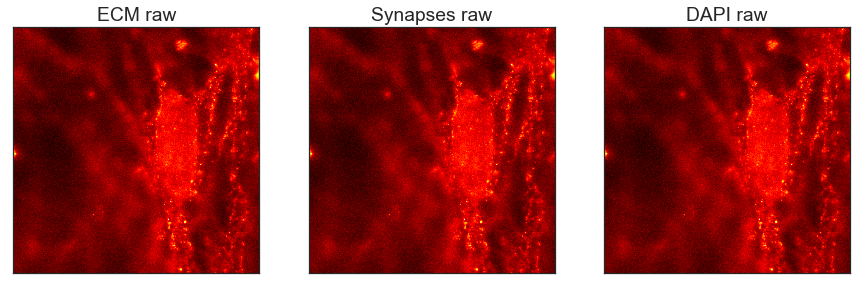

In [104]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
nuclei_channel_no=results["nucleichannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]
with ND2Reader(results["filename"][randomno]) as images:
    print("Image name:",results["filename"][randomno].split('/')[-1])
    print("Experimental condition:",results["exp condition"][randomno])
    ecm_image=images[ecm_channel_no-1]
    nuclei_image=images[nuclei_channel_no-1]
    synapse_image=images[synapse_channel_no-1]
    ###the part below just checks what filter was used in the microscope for the channels
    ###from the image metadata
    '''[channel1name, channel2name, channel3name]=ecm_image.metadata['channels']
    if ecm_channel_no==1:
        ecm_channelname=channel1name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel3name
        else:
            nuclei_channelname=channel3name
            synapse_channelname=channel2name
    if ecm_channel_no==2:
        ecm_channelname=channel2name
        if nuclei_channel_no==3:
            nuclei_channelname=channel3name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel3name
    if ecm_channel_no==3:
        ecm_channelname=channel3name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel2name'''
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(132)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Synapses raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(133)
plt.imshow(nuclei_image,interpolation='none',cmap='hot')
plt.title('DAPI raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)


### Masking
Make a mask for the image from the synapse channel - 
- Threshold with Li method (minimizing cross entropy)
- Make a separate mask for soma and neurites:
    - Find the soma by labelling the binary mask --> largest connected component = soma
    - Blur soma --> save this as soma mask
    - Blue remaining area --> save this as neurite mask

Text(0.5, 1.0, 'ECM raw image')

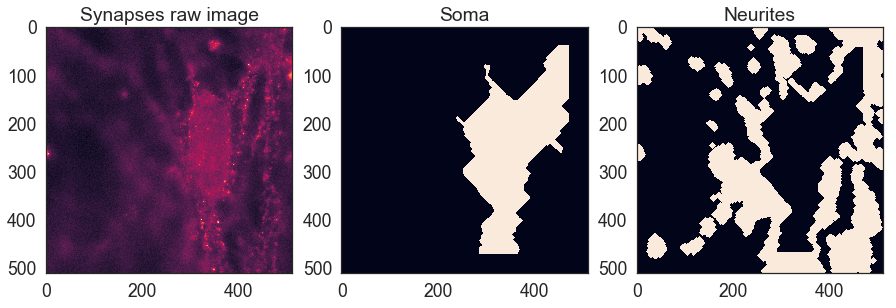

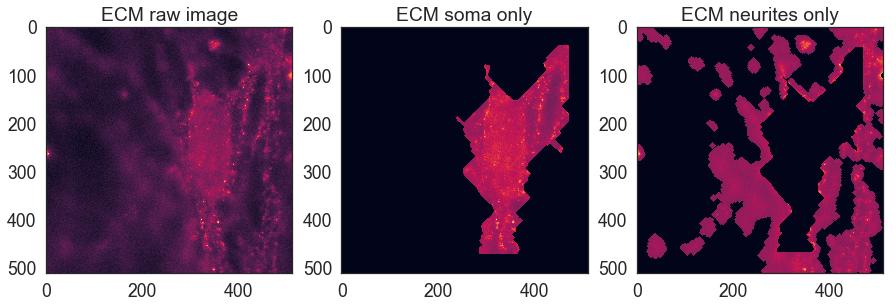

In [105]:
def makemask(synapse_image):
    #li thresholding
    synapse_image_threshold=threshold_li(synapse_image)
    synapse_image_thresholded=deepcopy(synapse_image)
    synapse_image_thresholded[synapse_image_thresholded<synapse_image_threshold]=0
    #find soma + some morphological operations
    synapse_labeled_mask, cc_num = ndi.label(synapse_image_thresholded)
    synapse_largest_cc_mask = (synapse_labeled_mask == (np.bincount(synapse_labeled_mask.flat)[1:].argmax() + 1))
    soma_mask=ndi.binary_closing(ndi.gaussian_filter(synapse_largest_cc_mask,sigma=1),iterations=40)
    #some morphological operations on the neurite mask
    neurite_mask=deepcopy(synapse_image_thresholded)
    neurite_mask[neurite_mask>np.percentile(neurite_mask,99.5)]=0
    neurite_mask[soma_mask]=0
    neurite_mask=ndi.gaussian_filter(neurite_mask,sigma=0.5)
    neurite_mask[neurite_mask>0]=1
    neurite_mask=ndi.binary_erosion(neurite_mask,iterations=4)
    neurite_mask=ndi.binary_dilation(neurite_mask,iterations=7)
    neurite_mask=ndi.binary_fill_holes(neurite_mask)
    return(soma_mask,neurite_mask)
    
#make temporary masked images to show what we will keep
ecm_somamasked=deepcopy(ecm_image)
ecm_neuritemasked=deepcopy(ecm_image)
soma_mask,neurite_mask=makemask(synapse_image)
ecm_somamasked[~soma_mask]=0
ecm_neuritemasked[~neurite_mask]=0
    
#show
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(synapse_image)
plt.title('Synapses raw image')
fig.add_subplot(132)
plt.imshow(soma_mask)
plt.title('Soma')
fig.add_subplot(133)
plt.imshow(neurite_mask)
plt.title('Neurites')

fig=plt.figure(figsize=(15,15))
fig.add_subplot(132)
plt.imshow(ecm_somamasked)
plt.title('ECM soma only')
fig.add_subplot(133)
plt.imshow(ecm_neuritemasked)
plt.title('ECM neurites only')
fig.add_subplot(131)
plt.imshow(ecm_image)
plt.title('ECM raw image')

<a id='segmenting'></a> 
#### Make segmentation masks for all images
After optimizing the parameters for preprocessing of the images, we can run the cleaning on all of the images in the experiment.

For each image we will save the **segmentation (spots) mask** which determines where the real signal is in the original image.

In [106]:
print('Total number of images: ' + str(len(results['filename'])))

for im in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(im+1) + 'of ' + str(len(results['filename'])))
    ecm_channel_no=results["ecmchannelno"][im]
    nuclei_channel_no=results["nucleichannelno"][im]
    synapse_channel_no=results["synapsechannelno"][im]
    with ND2Reader(results["filename"][im]) as images:
        ecm_image=images[ecm_channel_no-1]
        nuclei_image=images[nuclei_channel_no-1]
        synapse_image=images[synapse_channel_no-1]
        
    soma_mask,neurite_mask=makemask(synapse_image)
    
    results["Soma mask from synapse channel"].append(soma_mask)
    results["Neurites mask from synapse channel"].append(neurite_mask)
    clear_output()        

os.system('say "Segmentation complete"')
print("Done!")

Done!


**Backup the segmentation results before continuing**

We will copy the results dictionary that we've filled so far with the segmentation results, just in case...
Note - this copy stays alive along as this notebook stays alive, i.e. it isn't saved on the hard disk

In [107]:
resultsbackup=deepcopy(results)

*Restore results from backup, if needed:*

In [82]:
results=deepcopy(resultsbackup)

#### Optional: load manual segmentation masks from matlab GUI - soma and dendrites

In [108]:
for im in range(0,len(results["filename"])): 
    file=results["filename"][im][:-4]+'_somamask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual soma mask from matlab GUI"].append(mask)
    else:
        results["Manual soma mask from matlab GUI"].append(np.nan)
    file=results["filename"][im][:-4]+'_dendritemask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual neurites mask from matlab GUI"].append(mask)
    else:
        results["Manual neurites mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


In [96]:
resultsbackup=deepcopy(results)

### Visualize masking (automatic and manual, if exists) and background reduction for a few random images

Image name: 20190613_monensin_009.nd2
Experimental condition: monensin
ECM image - raw mean intensity =  996.2579765319824
ECM under soma - mean intensity =  2758.187105816398
ECM under soma - mean intensity after bg subtraction =  295.48465907686494
ECM under neurites - mean intensity =  1968.699041711032
ECM under neurites - mean intensity after bg subtraction =  335.557159748246
ECM under manual mask - mean intensity =  938.5572386929236
ECM under manual rois mask - mean intensity after bg subtraction =  71.99231601767588


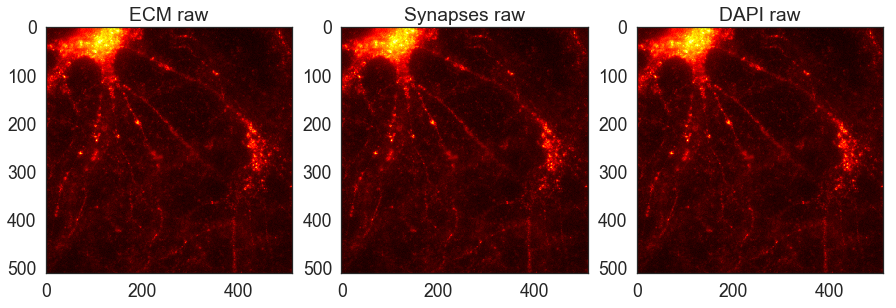

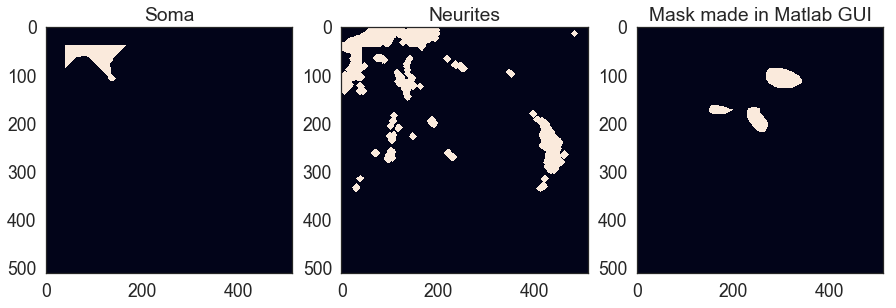

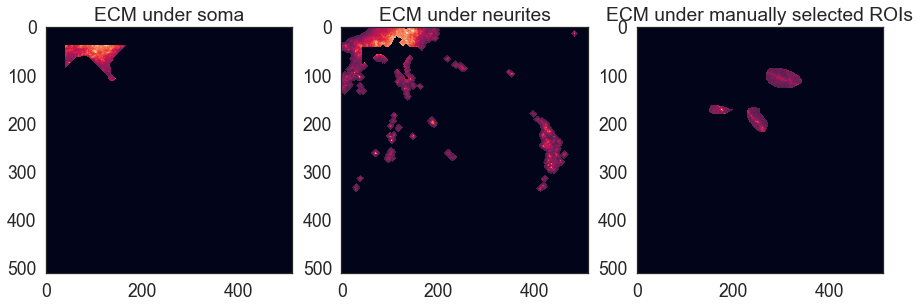

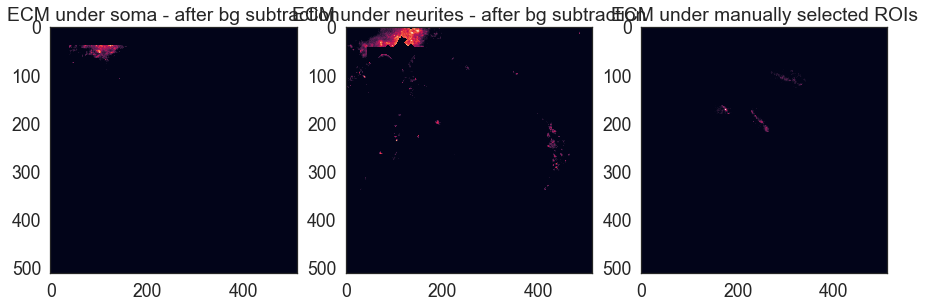

In [109]:
flag=False
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
nuclei_channel_no=results["nucleichannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]
soma_mask=results["Soma mask from synapse channel"][randomno]
neurites_mask=results["Neurites mask from synapse channel"][randomno]
matlab_mask=results["Manual neurites mask from matlab GUI"][randomno]

with ND2Reader(results["filename"][randomno]) as images:
    print("Image name:",results["filename"][randomno].split('/')[-1])
    print("Experimental condition:",results["exp condition"][randomno])
    ecm_image=images[ecm_channel_no-1]
    nuclei_image=images[nuclei_channel_no-1]
    synapse_image=images[synapse_channel_no-1]
    ###the part below just checks what filter was used in the microscope for the channels
    ###from the image metadata
    '''[channel1name, channel2name, channel3name]=ecm_image.metadata['channels']
    if ecm_channel_no==1:
        ecm_channelname=channel1name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel3name
        else:
            nuclei_channelname=channel3name
            synapse_channelname=channel2name
    if ecm_channel_no==2:
        ecm_channelname=channel2name
        if nuclei_channel_no==3:
            nuclei_channelname=channel3name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel3name
    if ecm_channel_no==3:
        ecm_channelname=channel3name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel2name'''
            
#make temporary masked images to show what we will keep
ecm_somamasked=deepcopy(ecm_image)
ecm_neuritemasked=deepcopy(ecm_image)
ecm_somamasked[~soma_mask]=0
ecm_neuritemasked[~neurites_mask]=0
ecm_matlabmasked=deepcopy(ecm_image)
synapses_matlabmasked=deepcopy(synapse_image)
if type(matlab_mask)==np.ndarray:
    ecm_matlabmasked[~matlab_mask]=0
    synapses_matlabmasked[~matlab_mask]=0
    flag=True

figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
figure.add_subplot(132)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Synapses raw')
figure.add_subplot(133)
plt.imshow(nuclei_image,interpolation='none',cmap='hot')
plt.title('DAPI raw')

#show masks
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(soma_mask)
plt.title('Soma')
fig.add_subplot(132)
plt.imshow(neurites_mask)
plt.title('Neurites')
fig.add_subplot(133)
if flag==True:
    plt.imshow(matlab_mask)
    plt.title('Mask made in Matlab GUI')
else:
    plt.imshow(np.zeros([512,512]))
    plt.title('Mask made in Matlab GUI - no mask was made') 
#show masked images
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(ecm_somamasked)
plt.title('ECM under soma')
fig.add_subplot(132)
plt.imshow(ecm_neuritemasked)
plt.title('ECM under neurites')
fig.add_subplot(133)
if flag==True:
    plt.imshow(ecm_matlabmasked)
    plt.title('ECM under manually selected ROIs')
else:
    plt.imshow(ecm_matlabmasked)
    plt.title('No manual mask was made') 
#background subtraction    
bg_somamask=np.mean(ndi.median_filter(ecm_image[soma_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[soma_mask],size=5))
ecm_somamasked_bgreduced=deepcopy(ecm_image)
ecm_somamasked_bgreduced=np.subtract(ecm_somamasked_bgreduced,bg_somamask)
ecm_somamasked_bgreduced[ecm_somamasked_bgreduced<0]=0
ecm_somamasked_bgreduced[~soma_mask]=0
bg_neuritesmask=np.mean(ndi.median_filter(ecm_image[neurites_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[neurites_mask],size=5))
ecm_neuritesmasked_bgreduced=deepcopy(ecm_image)
ecm_neuritesmasked_bgreduced=np.subtract(ecm_neuritesmasked_bgreduced,bg_neuritesmask)
ecm_neuritesmasked_bgreduced[ecm_neuritesmasked_bgreduced<0]=0
ecm_neuritesmasked_bgreduced[~neurites_mask]=0
ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
if flag==True:
    bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
    ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
    ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
    ecm_matlabmasked_bgreduced[~matlab_mask]=0

#show bg subtracted masked images
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(ecm_somamasked_bgreduced)
plt.title('ECM under soma - after bg subtraction')
fig.add_subplot(132)
plt.imshow(ecm_neuritesmasked_bgreduced)
plt.title('ECM under neurites - after bg subtraction')
fig.add_subplot(133)
if flag==True:
    plt.imshow(ecm_matlabmasked_bgreduced)
    plt.title('ECM under manually selected ROIs')
else:
    plt.imshow(ecm_matlabmasked_bgreduced)
    plt.title('No manual mask was made')
#calculate intensities before/after bg subtraction
print('ECM image - raw mean intensity = ',np.nanmean(ecm_image))
print('ECM under soma - mean intensity = ',np.nanmean(ecm_image[soma_mask]))
print('ECM under soma - mean intensity after bg subtraction = ', np.nanmean(ecm_somamasked_bgreduced[soma_mask]))
print('ECM under neurites - mean intensity = ',np.nanmean(ecm_image[neurites_mask]))
print('ECM under neurites - mean intensity after bg subtraction = ', np.nanmean(ecm_neuritesmasked_bgreduced[neurites_mask]))
if flag==True:
    print('ECM under manual mask - mean intensity = ',np.nanmean(ecm_image[matlab_mask]))
    print('ECM under manual rois mask - mean intensity after bg subtraction = ', np.nanmean(ecm_matlabmasked_bgreduced[matlab_mask]))

<a id='quantitativeimageanalysis'></a> 
### Quanitative image analysis

Now we can extract some numbers from our processed images. We'll extract a lot of data - you never know what could be interesting, and we don't have to use it all.

Beforehand, we will calculate the mean intensity of the non-blocked control images, so that we can use this later in the analysis

### **Now we can run the analysis in a loop over all the images**

This will take a while...

In [110]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    ecm_channel_no=results["ecmchannelno"][i]
    nuclei_channel_no=results["nucleichannelno"][i]
    synapse_channel_no=results["synapsechannelno"][i]
    with ND2Reader(results["filename"][i]) as images:
        ecm_image=images[ecm_channel_no-1]
        nuclei_image=images[nuclei_channel_no-1]
        synapse_image=images[synapse_channel_no-1]
    #convert to numpy array - a format easier to manipunuclei with code
    ecm_image=ecm_image.astype(np.int16)
    nuclei_image=nuclei_image.astype(np.int16)
    synapse_image=synapse_image.astype(np.int16)
    
    ###################analyses for the raw images -before processing##############
    #preserve the raw images
    ecm_image_raw = deepcopy(ecm_image)
    nuclei_image_raw=deepcopy(nuclei_image)
    synapse_image_raw=deepcopy(synapse_image)
    #normalize intensity to value between 0 and 1 - also just to make them easier to work with
    ecm_image=np.divide(ecm_image,16383.)
    nuclei_image=np.divide(nuclei_image,16383.)
    synapse_image=np.divide(synapse_image,16383.)
    #read masks
    soma_mask=results["Soma mask from synapse channel"][i]
    neurites_mask=results["Neurites mask from synapse channel"][i]
    matlab_somamask=results["Manual soma mask from matlab GUI"][i]
    matlab_dendritesmask=results["Manual neurites mask from matlab GUI"][i]
    if type(matlab_mask)==np.ndarray:
        flag=True
    #images after background subtraction
    #for ecm image
    bg_somamask=np.mean(ndi.median_filter(ecm_image[soma_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[soma_mask],size=5))
    ecm_somamasked_bgreduced=deepcopy(ecm_image)
    ecm_somamasked_bgreduced=np.subtract(ecm_somamasked_bgreduced,bg_somamask)
    ecm_somamasked_bgreduced[ecm_somamasked_bgreduced<0]=0
    ecm_somamasked_bgreduced[~soma_mask]=0
    bg_neuritesmask=np.mean(ndi.median_filter(ecm_image[neurites_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[neurites_mask],size=5))
    ecm_neuritesmasked_bgreduced=deepcopy(ecm_image)
    ecm_neuritesmasked_bgreduced=np.subtract(ecm_neuritesmasked_bgreduced,bg_neuritesmask)
    ecm_neuritesmasked_bgreduced[ecm_neuritesmasked_bgreduced<0]=0
    ecm_neuritesmasked_bgreduced[~neurites_mask]=0
    ecm_matlabsomamasked_bgreduced=deepcopy(ecm_image)
    ecm_matlabdendritesmasked_bgreduced=deepcopy(ecm_image)
    if flag==True:
        bg_matlabsomamask=np.mean(ndi.median_filter(ecm_image[matlab_somamask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_somamask],size=5))
        ecm_matlabsomamasked_bgreduced=np.subtract(ecm_matlabsomamasked_bgreduced,bg_matlabsomamask)
        ecm_matlabsomamasked_bgreduced[ecm_matlabsomamasked_bgreduced<0]=0
        ecm_matlabsomamasked_bgreduced[~matlab_somamask]=0
        bg_matlabdendritesmask=np.mean(ndi.median_filter(ecm_image[matlab_dendritesmask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_dendritesmask],size=5))
        ecm_matlabdendritesmasked_bgreduced=np.subtract(ecm_matlabdendritesmasked_bgreduced,bg_matlabdendritesmask)
        ecm_matlabdendritesmasked_bgreduced[ecm_matlabdendritesmasked_bgreduced<0]=0
        ecm_matlabdendritesmasked_bgreduced[~matlab_dendritesmask]=0
    #for synapse image
    bg_somamask=np.mean(ndi.median_filter(synapse_image[soma_mask],size=5))+0*np.std(ndi.median_filter(synapse_image[soma_mask],size=5))
    synapse_somamasked_bgreduced=deepcopy(synapse_image)
    synapse_somamasked_bgreduced=np.subtract(synapse_somamasked_bgreduced,bg_somamask)
    synapse_somamasked_bgreduced[synapse_somamasked_bgreduced<0]=0
    synapse_somamasked_bgreduced[~soma_mask]=0
    bg_neuritesmask=np.mean(ndi.median_filter(synapse_image[neurites_mask],size=5))+0*np.std(ndi.median_filter(synapse_image[neurites_mask],size=5))
    synapse_neuritesmasked_bgreduced=deepcopy(synapse_image)
    synapse_neuritesmasked_bgreduced=np.subtract(synapse_neuritesmasked_bgreduced,bg_neuritesmask)
    synapse_neuritesmasked_bgreduced[synapse_neuritesmasked_bgreduced<0]=0
    synapse_neuritesmasked_bgreduced[~neurites_mask]=0
    synapse_matlabmasked_bgreduced=deepcopy(synapse_image)
    if flag==True:
        bg_matlabmask=np.mean(ndi.median_filter(synapse_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(synapse_image[matlab_mask],size=5))
        synapse_matlabmasked_bgreduced=np.subtract(synapse_matlabmasked_bgreduced,bg_matlabmask)
        synapse_matlabmasked_bgreduced[synapse_matlabmasked_bgreduced<0]=0
        synapse_matlabmasked_bgreduced[~matlab_mask]=0
    #make raw ecm images normalized to the raw intensity of the non-blocked controls 
    ecm_image_normtoctrl=deepcopy(ecm_image)
    ecm_ctrl_mean=1
    ecm_image_normtoctrl=np.divide(ecm_image_normtoctrl,ecm_ctrl_mean)
    #make histograms of the raw images
    ecm_hist,_ = np.histogram(ecm_image,bins=np.linspace(0.,1.,50))
    nuclei_hist,_ = np.histogram(nuclei_image,bins=np.linspace(0.,1.,50))
    synapse_hist,_ = np.histogram(synapse_image,bins=np.linspace(0.,1.,50))
    ##################################################################################    

#append the final results to the dictionary:
    #results based on calculation on raw images
    results["ECM raw intensity, unmasked"].append(np.nanmean(ecm_image_raw))
    results["Nuclei raw intensity, unmasked"].append(np.nanmean(nuclei_image_raw))
    results["Synapse raw intensity, unmasked"].append(np.nanmean(synapse_image_raw))
    results["ECM intensity: unmasked, divded by unblocked condition"].append(np.nanmean(ecm_image_normtoctrl))
    histogram_results["ECM raw intensity- Flattened histogram"].append(ecm_hist) 
    histogram_results["Nuclei raw intensity- Flattened histogram"].append(nuclei_hist)
    histogram_results["Synapse raw intensity- Flattened histogram"].append(synapse_hist)
    #results under mask
    results["ECM mean intensity: soma only"].append(np.nanmean(ecm_image[soma_mask]))
    results["ECM mean intensity: soma only, divided by unblocked"].append(np.nanmean(ecm_image_normtoctrl[soma_mask]))
    results["ECM mean intensity: neurites only"].append(np.nanmean(ecm_image[neurites_mask]))
    results["ECM mean intensity: neurites only, divided by unblocked"].append(np.nanmean(ecm_image_normtoctrl[neurites_mask]))
    if flag==True:
        results["ECM mean intensity: matlab manual soma mask only"].append(np.nanmean(ecm_image[matlab_somamask]))
        results["ECM mean intensity: matlab manual soma mask only, divided by unblocked"].append(np.nanmean(ecm_image_normtoctrl[matlab_somamask]))
        results["ECM mean intensity: matlab manual neurites mask only"].append(np.nanmean(ecm_image[matlab_dendritesmask]))
        results["ECM mean intensity: matlab manual neurites mask only, divided by unblocked"].append(np.nanmean(ecm_image_normtoctrl[matlab_dendritesmask]))
    else:
        results["ECM mean intensity: matlab manual soma mask only"].append(np.nan)
        results["ECM mean intensity: matlab manual neurites mask only"].append(np.nan)
    results["Synapse mean intensity: soma only"].append(np.nanmean(synapse_image[soma_mask]))
    results["Synapse mean intensity: neurites only"].append(np.nanmean(synapse_image[neurites_mask]))
    if flag==True:
        results["Synapse mean intensity: matlab manual mask only"].append(np.nanmean(synapse_image[matlab_mask]))
    else:
        results["Synapse mean intensity: matlab manual mask only"].append(np.nan)
    results["Nuclei mean intensity: soma only"].append(np.nanmean(nuclei_image[soma_mask]))
    results["Nuclei mean intensity: neurites only"].append(np.nanmean(nuclei_image[neurites_mask]))
    if flag==True:
        results["Nuclei mean intensity: matlab manual mask only"].append(np.nanmean(nuclei_image[neurites_mask]))
    else:
        results["Nuclei mean intensity: matlab manual mask only"].append(np.nan)
    synapse_image_threshold=threshold_li(synapse_image)
    synapse_image_thresholded=deepcopy(synapse_image)
    synapse_image_thresholded[synapse_image_thresholded<synapse_image_threshold]=0
    synapse_soma=deepcopy(synapse_image_thresholded)
    synapse_soma[~soma_mask]=0
    synapse_neurites=deepcopy(synapse_image_thresholded)
    synapse_neurites[~neurites_mask]=0
    synapse_labeled_mask_soma, cc_num_soma = ndi.label(synapse_soma)
    synapse_labeled_mask_neurites, cc_num_neurites = ndi.label(synapse_neurites)
    results["Number of synapse spots in soma mask"].append(cc_num_soma)
    results["Number of synapse spots in neurites mask"].append(cc_num_neurites)
    if flag==True:
        synapse_matlab=deepcopy(synapse_image_thresholded)
        synapse_matlab[~matlab_mask]=0
        synapse_labeled_mask_matlab, cc_num_matlab = ndi.label(synapse_matlab)
        results["Number of synapse spots in matlab manual mask"].append(cc_num_matlab)
    else:
        results["Number of synapse spots in matlab manual mask"].append(np.nan)
    nuclei_image_threshold=threshold_li(nuclei_image)
    nuclei_image_thresholded=deepcopy(nuclei_image)
    nuclei_image_thresholded[nuclei_image_thresholded<nuclei_image_threshold]=0
    nuclei_soma=deepcopy(nuclei_image_thresholded)
    nuclei_soma[~soma_mask]=0
    nuclei_neurites=deepcopy(nuclei_image_thresholded)
    nuclei_neurites[~neurites_mask]=0
    nuclei_labeled_mask_soma, cc_num_soma = ndi.label(nuclei_soma)
    nuclei_labeled_mask_neurites, cc_num_neurites = ndi.label(nuclei_neurites)
    results["Number of nuclei spots in soma mask"].append(cc_num_soma)
    results["Number of nuclei spots in neurites mask"].append(cc_num_neurites)
    if flag==True:
        nuclei_matlab=deepcopy(nuclei_image_thresholded)
        nuclei_matlab[~matlab_mask]=0
        nuclei_labeled_mask_matlab, cc_num_matlab = ndi.label(nuclei_matlab)
        results["Number of nuclei spots in matlab manual mask"].append(cc_num_matlab)
    else:
        results["Number of nuclei spots in matlab manual mask"].append(np.nan)
    #results after background subtraction
    results["ECM mean intensity after bg subtraction: soma only"].append(np.nanmean(ecm_somamasked_bgreduced[soma_mask]))
    results["ECM mean intensity after bg subtraction: soma only, divided by unblocked"].append(np.divide(np.nanmean(ecm_somamasked_bgreduced[soma_mask]),ecm_ctrl_mean))
    results["ECM mean intensity after bg subtraction: neurites only"].append(np.nanmean(ecm_neuritesmasked_bgreduced[neurites_mask]))
    results["ECM mean intensity after bg subtraction: neurites only, divided by unblocked"].append(np.divide(np.nanmean(ecm_neuritesmasked_bgreduced[neurites_mask]),ecm_ctrl_mean))
    if flag==True:
        results["ECM mean intensity after bg subtraction: matlab manual soma mask only"].append(np.nanmean(ecm_matlabsomamasked_bgreduced[matlab_somamask]))
        results["ECM mean intensity after bg subtraction: matlab manual soma mask only, divided by unblocked"].append(np.divide(np.nanmean(ecm_matlabsomamasked_bgreduced[matlab_somamask]),ecm_ctrl_mean))
        results["ECM mean intensity after bg subtraction: matlab manual neurites mask only"].append(np.nanmean(ecm_matlabdendritesmasked_bgreduced[matlab_dendritesmask]))
        results["ECM mean intensity after bg subtraction: matlab manual neurites mask only, divided by unblocked"].append(np.divide(np.nanmean(ecm_matlabdendritesmasked_bgreduced[matlab_dendritesmask]),ecm_ctrl_mean))
    else:
        results["ECM mean intensity after bg subtraction: matlab manual soma mask only"].append(np.nan)
        results["ECM mean intensity after bg subtraction: matlab manual soma mask only, divided by unblocked"].append(np.nan)
        results["ECM mean intensity after bg subtraction: matlab manual neurites mask only"].append(np.nan)
        results["ECM mean intensity after bg subtraction: matlab manual neurites mask only, divided by unblocked"].append(np.nan)
    
    
    results["Synapse mean intensity after bg subtraction: soma only"].append(np.nanmean(synapse_somamasked_bgreduced[soma_mask]))
    results["Synapse mean intensity after bg subtraction: neurites only"].append(np.nanmean(synapse_neuritesmasked_bgreduced[neurites_mask]))
    if flag==True:
        results["Synapse mean intensity after bg subtraction: matlab manual mask only"].append(np.nanmean(synapse_matlabmasked_bgreduced[matlab_mask]))
    else:
        results["Synapse mean intensity after bg subtraction: matlab manual mask only"].append(np.nan)
    synapse_soma=deepcopy(synapse_somamasked_bgreduced)
    synapse_neurites=deepcopy(synapse_neuritesmasked_bgreduced)
    synapse_soma[~soma_mask]=0
    synapse_neurites[~neurites_mask]=0
    synapse_labeled_mask_soma, cc_num_soma = ndi.label(synapse_soma)
    synapse_labeled_mask_neurites, cc_num_neurites = ndi.label(synapse_neurites)
    results["Number of synapse spots in soma mask after bg subtraction"].append(cc_num_soma)
    results["Number of synapse spots in neurites mask after bg subtraction"].append(cc_num_neurites)
    if flag==True:
        synapse_matlab=deepcopy(synapse_matlabmasked_bgreduced)
        synapse_matlab[~matlab_mask]=0
        synapse_labeled_mask_matlab, cc_num_matlab = ndi.label(synapse_matlab)
        results["Number of synapse spots in matlab manual mask after bg subtraction"].append(cc_num_matlab)
    else:
        results["Number of synapse spots in matlab manual mask after bg subtraction"].append(np.nan)
    nuclei_image_threshold=threshold_li(nuclei_image)
    nuclei_image_thresholded=deepcopy(nuclei_image)
    nuclei_image_thresholded[nuclei_image_thresholded<nuclei_image_threshold]=0
    nuclei_soma=deepcopy(nuclei_image_thresholded)
    nuclei_soma[~soma_mask]=0
    nuclei_neurites=deepcopy(nuclei_image_thresholded)
    nuclei_neurites[~neurites_mask]=0
    nuclei_labeled_mask_soma, cc_num_soma = ndi.label(nuclei_soma)
    nuclei_labeled_mask_neurites, cc_num_neurites = ndi.label(nuclei_neurites)
    results["Number of nuclei spots in soma mask after bg subtraction"].append(cc_num_soma)
    results["Number of nuclei spots in neurites mask after bg subtraction"].append(cc_num_neurites)
    if flag==True:
        nuclei_matlab=deepcopy(nuclei_image_thresholded)
        nuclei_matlab[~matlab_mask]=0
        nuclei_labeled_mask_matlab, cc_num_matlab = ndi.label(nuclei_matlab)
        results["Number of nuclei spots in matlab manual mask after bg subtraction"].append(cc_num_matlab)
    else:
        results["Number of nuclei spots in matlab manual mask after bg subtraction"].append(np.nan)
    #save the region properties of the spots masks, for future analysis
    synapseprops_soma=skimage.measure.regionprops(synapse_labeled_mask_soma)   
    synapseprops_neurites=skimage.measure.regionprops(synapse_labeled_mask_neurites)                                                                             
    regionprops_results["Synapse colour - regionprops soma"].append(synapseprops_soma)
    regionprops_results["Synapse colour - regionprops neurites"].append(synapseprops_neurites)
    clear_output()
    flag=False
os.system('say "Finished batch analyzing"')
print('Done!')

Done!


<a id='plots'></a> 
## Visualization - plots

Now we can make some plots from our data to understand the results. To do this we will first convert our results dictionary into a python *DataFrame*. This is a format used in the Python package Pandas, and it's very handy for data analysis and plotting. It's similar to a spreadsheet (e.g. Excel), except that each cell can hold any type of data you want, even matrices.

In [111]:
del(results["noblock_controldir"])

In [72]:
del(results["ECM mean intensity: matlab manual neurites mask only, divided by unblocked"])
del(results["ECM mean intensity: matlab manual soma mask only, divided by unblocked"])

In [112]:
for key in results.keys():
    print(key)
    print(len(results[key]))

filename
90
ecmchannelno
90
nucleichannelno
90
synapsechannelno
90
Soma mask from synapse channel
90
Neurites mask from synapse channel
90
Manual soma mask from matlab GUI
90
Manual neurites mask from matlab GUI
90
exp condition
90
ECM raw intensity, unmasked
90
Nuclei raw intensity, unmasked
90
Synapse raw intensity, unmasked
90
ECM intensity: unmasked, divded by unblocked condition
90
ECM mean intensity: soma only
90
ECM mean intensity: soma only, divided by unblocked
90
ECM mean intensity: neurites only
90
ECM mean intensity: neurites only, divided by unblocked
90
ECM mean intensity: matlab manual soma mask only
90
ECM mean intensity: matlab manual soma mask only, divided by unblocked
90
ECM mean intensity: matlab manual neurites mask only
90
ECM mean intensity: matlab manual neurites mask only, divided by unblocked
90
Synapse mean intensity: soma only
90
Synapse mean intensity: neurites only
90
Synapse mean intensity: matlab manual mask only
90
Nuclei mean intensity: soma only
90
N

In [113]:
df=pd.DataFrame(results)
df['expname']=filelist[i].split("/")[:-2][-1]#add exp id
#dfhists=pd.DataFrame(histogram_results)
#dfregionprops=pd.DataFrame(regionprops_results)

Before continuing, we will make a new folder called 'results' inside our experiment folder, and backup the dataframes as csv (comma separated value) files:

In [114]:
#os.mkdir(expdir+protein+'_results/')
expname=filelist[i].split("/")[:-2][-1]
df.to_csv(path_or_buf=expdir+protein+'_results/results_'+str(protein)+'.csv')
#dfhists.to_csv(path_or_buf=expdir+protein+'_results/histogram_results_'+str(protein)+'.csv')
#dfregionprops.to_csv(path_or_buf=expdir+protein+'_results/regionprops_results_'+str(protein)+'.csv')

**Load an existing DataFrame**
If we want to plot the results that we already created and saved, we can load the csv file and convert it back into a DataFrame:

In [174]:
#df=pd.read_csv(expdir+protein+'_results/results_'+str(protein)+'.csv')
df=pd.read_csv(expdir+protein+'_results/results_'+str(protein)+'.csv')
#dfhists=pd.read_csv(expdir+'results/histogram_results.csv')
#dfregionprops=pd.read_csv(expdir+'results/regionprops_results.csv')

Let's take a quick look at a few rows in the results DataFrame to see that it looks okay:

<a id='checknormality'></a> 
**How does the intensity distribute?**

Ultimately, we will mostly be comparing the mean fluorescence intensity between different experimental conditions (e.g. different times, different drugs..). It might be useful to see how the mean fluorescence intensity distributes, both in total and in different conditions. So, we can start by looking at histograms of the different variables. Also, we can use the Kolmogorov–Smirnov statistical test to see if our data distributes normally. If it doesn't (which is often the case), we may want to consider using a non-parametric statistical analysis later on.

*Note: I often like to use a Python package called Seaborn (which i shorten to sns in my code) to make pretty plots

<class 'numpy.ndarray'>
The variable distributes normally


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won'

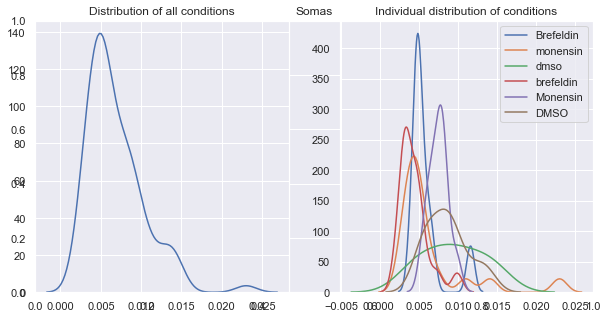

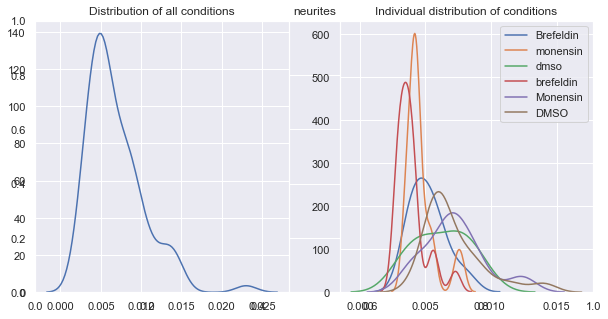

In [115]:
#variable="ECM raw intensity, unmasked" #change me
variable="ECM mean intensity after bg subtraction: matlab manual soma mask only"
variable2="ECM mean intensity after bg subtraction: matlab manual neurites mask only"


x=df[variable].values
normdvar=(x-x.mean())/x.std()
print(type(normdvar))

import scipy.stats as ss
[_,pval]=ss.kstest(normdvar,'norm')
if pval<0.05:
    print("The variable does not distribute normally")
else:
    print("The variable distributes normally")

    sns.set(font_scale=1)
fig=plt.figure(figsize=(10,5))
plt.title('Somas')
fig.add_subplot(121)
sns.kdeplot(df[variable],legend=False)
plt.title('Distribution of all conditions')
fig.add_subplot(122)
for condition in list(set(df["exp condition"])):
    sns.kdeplot(df[df["exp condition"]==condition][variable],legend=False)
    
    plt.legend(list(set(df["exp condition"])),loc='upper right')
    plt.title('Individual distribution of conditions')
    
fig=plt.figure(figsize=(10,5))
plt.title('neurites')
fig.add_subplot(121)
sns.kdeplot(df[variable],legend=False)
plt.title('Distribution of all conditions')
fig.add_subplot(122)
for condition in list(set(df["exp condition"])):
    sns.kdeplot(df[df["exp condition"]==condition][variable2],legend=False)
    
    plt.legend(list(set(df["exp condition"])),loc='upper right')
    plt.title('Individual distribution of conditions')
    

#### Removing outliers

In [116]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#### Defining variables to plot from dataframe

In [117]:
vars2plot=df._get_numeric_data().columns #gives the names of the numeric columns only

<a id='makingsense'></a> 
### Making sense

Let's add some human-understandable tags to the DataFrame, so that we can plot what we want more easily.
- A tag for the incubation time
- A tag for the treatment condition (Bic/DMSO)

In [118]:
df2=deepcopy(df)
df2.loc[df2['exp condition'].str.contains('refeldin'), 'Drug'] = 'Brefeldin'
df2.loc[df2['exp condition'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df2.loc[df2['exp condition'].str.contains('dmso'), 'Drug'] = 'DMSO'


df2.loc[df2['exp condition'].str.contains('onensin'), 'Drug'] = 'Monensin'

## Make plots to present

### look at exps separately

### Plt from 12.5.19

<Figure size 432x288 with 0 Axes>

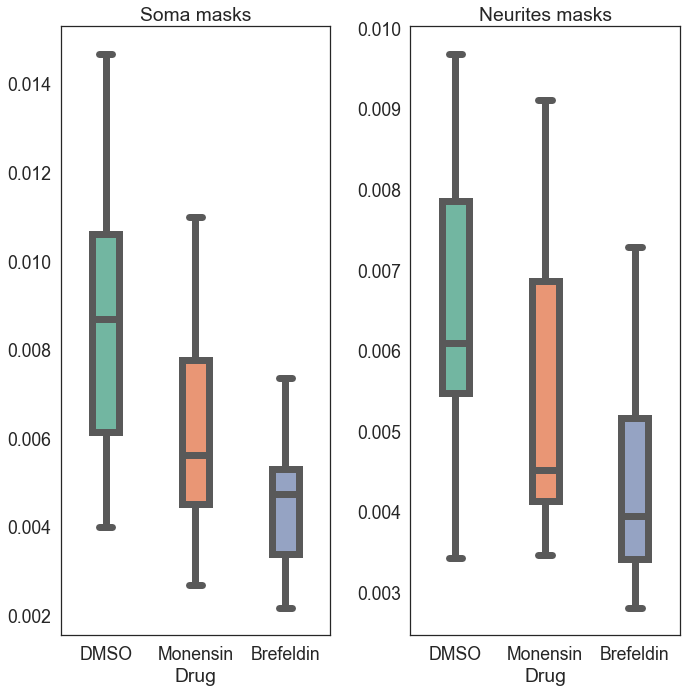

In [119]:
sns.set(font_scale=1.6)
sns.set_style("white")
sns.despine()
sns.set_palette("Set2")

df_to_plot=df2
hueselector=None
x_labels="Drug"
y_axis="ECM mean intensity after bg subtraction: matlab manual soma mask only"
y_axis_neurites="ECM mean intensity after bg subtraction: matlab manual neurites mask only"
var=y_axis
plot_order=["DMSO","Monensin","Brefeldin"]   
#plot
fig=plt.figure(figsize=(10,10))
fig.add_subplot(121)
d=sns.boxplot(y=y_axis,x=x_labels,data=df_to_plot,linewidth=7,
              hue=hueselector,order=plot_order,width=0.3,showfliers=False)
plt.title('Soma masks')
plt.ylabel('')
plot_ordery=plot_order 
fig.add_subplot(122)
d=sns.boxplot(y=y_axis_neurites,x=x_labels,data=df_to_plot,linewidth=7,
              hue=hueselector,order=plot_order,width=0.3,showfliers=False)

plot_ordery=plot_order
plt.title('Neurites masks')
plt.ylabel('')
fig.tight_layout()

### With stats

0.07619957552974223
8.882905080376408e-07
0.09650215938167031
0.05517591197118875
5.968881852075404e-06
0.03217448539375405


<Figure size 432x288 with 0 Axes>

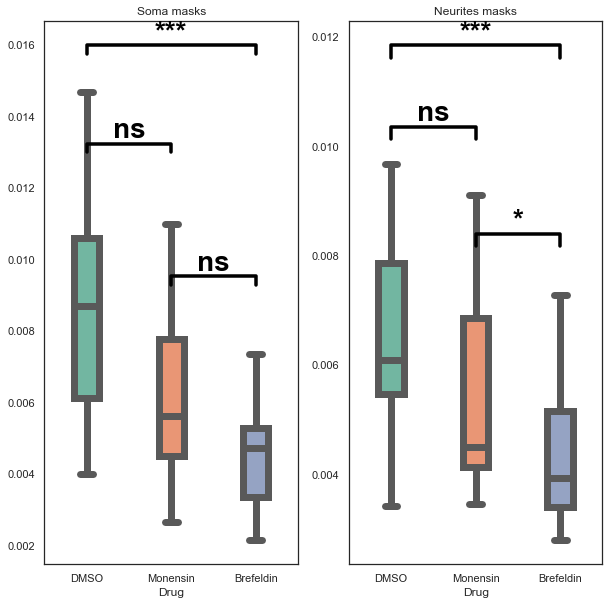

In [121]:
sns.set(font_scale=2.5)
sns.set()
sns.set_style("white")
sns.despine()
sns.set_palette("Set2")

df_to_plot=df2
hueselector=None
x_labels="Drug"
y_axis="ECM mean intensity after bg subtraction: matlab manual soma mask only"
var=y_axis
plot_order=["DMSO","Monensin","Brefeldin"]   

#plot

#somas
fig=plt.figure(figsize=(10,10))
fig.add_subplot(121)
d=sns.boxplot(y=y_axis,x=x_labels,data=df_to_plot,linewidth=7,
              hue=hueselector,order=plot_order,width=0.3,showfliers=False)
plt.title('Soma masks')
plt.ylabel('')
plot_ordery=plot_order 

dmso=df_to_plot[df_to_plot["Drug"]==plot_ordery[0]][var].dropna()
monensin=df_to_plot[df_to_plot["Drug"]==plot_ordery[1]][var].dropna()
brefeldin=df_to_plot[df_to_plot["Drug"]==plot_ordery[2]][var].dropna()

[stat,pval_dmso_monen]=stats.ttest_ind(monensin.dropna(), dmso.dropna())
[stat,pval_dmso_bref]=stats.ttest_ind(brefeldin.dropna(), dmso.dropna())
[stat,pval_monen_bref]=stats.ttest_ind(brefeldin.dropna(), monensin.dropna())

pval_dmso_monen=pval_dmso_monen*3
pval_dmso_bref=pval_dmso_bref*3
pval_monen_bref=pval_monen_bref*3
print(pval_dmso_monen)
print(pval_dmso_bref)
print(pval_monen_bref)

pval=pval_dmso_monen
x1, x2 = 0,1
y= 1.35*df_to_plot[df_to_plot["Drug"]==plot_ordery[0]][var].quantile(.7)
h=0.01*df_to_plot[y_axis].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=28, weight='bold')
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=28, weight='bold')
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=28, weight='bold')
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=28, weight='bold')

pval=pval_dmso_bref
x1, x2 = 0,2
y= 1.35*df_to_plot[df_to_plot["Drug"]==plot_ordery[0]][var].quantile(.8)
h=0.01*df_to_plot[y_axis].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=28, weight='bold')
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=28, weight='bold')
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=28, weight='bold')
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=28, weight='bold')

pval=pval_monen_bref
x1, x2 = 1,2
y= 1.35*df_to_plot[df_to_plot["Drug"]==plot_ordery[2]][var].quantile(.9)
h=0.01*df_to_plot[y_axis].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=28, weight='bold')
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=28, weight='bold')
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=28, weight='bold')
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=28, weight='bold')
    
#neurites
fig.add_subplot(122)
d=sns.boxplot(y=y_axis_neurites,x=x_labels,data=df_to_plot,linewidth=7,
              hue=hueselector,order=plot_order,width=0.3,showfliers=False)
plt.title('Neurites masks')
plt.ylabel('')
plot_ordery=plot_order 

var=y_axis_neurites
dmso=df_to_plot[df_to_plot["Drug"]==plot_ordery[0]][var].dropna()
monensin=df_to_plot[df_to_plot["Drug"]==plot_ordery[1]][var].dropna()
brefeldin=df_to_plot[df_to_plot["Drug"]==plot_ordery[2]][var].dropna()

[stat,pval_dmso_monen]=stats.ttest_ind(monensin.dropna(), dmso.dropna())
[stat,pval_dmso_bref]=stats.ttest_ind(brefeldin.dropna(), dmso.dropna())
[stat,pval_monen_bref]=stats.ttest_ind(brefeldin.dropna(), monensin.dropna())

pval_dmso_monen=pval_dmso_monen*3
pval_dmso_bref=pval_dmso_bref*3
pval_monen_bref=pval_monen_bref*3
print(pval_dmso_monen)
print(pval_dmso_bref)
print(pval_monen_bref)

pval=pval_dmso_monen
x1, x2 = 0,1
y= 1.35*df_to_plot[df_to_plot["Drug"]==plot_ordery[0]][var].quantile(.7)
h=0.01*df_to_plot[y_axis].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=28, weight='bold')
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=28, weight='bold')
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=28, weight='bold')
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=28, weight='bold')

pval=pval_dmso_bref
x1, x2 = 0,2
y= 1.35*df_to_plot[df_to_plot["Drug"]==plot_ordery[0]][var].quantile(.8)
h=0.01*df_to_plot[y_axis].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=28, weight='bold')
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=28, weight='bold')
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=28, weight='bold')
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=28, weight='bold')

pval=pval_monen_bref
x1, x2 = 1,2
y= 1.35*df_to_plot[df_to_plot["Drug"]==plot_ordery[2]][var].quantile(.9)
h=0.01*df_to_plot[y_axis].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=28, weight='bold')
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=28, weight='bold')
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=28, weight='bold')
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=28, weight='bold')

## 